In [26]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import datetime

In [27]:
access = pd.read_csv("UserAccess.csv")
action = pd.read_csv("UserAction.csv")
purchase = pd.read_csv("UserPurchase.csv")

Text(0, 0.5, 'Login User')

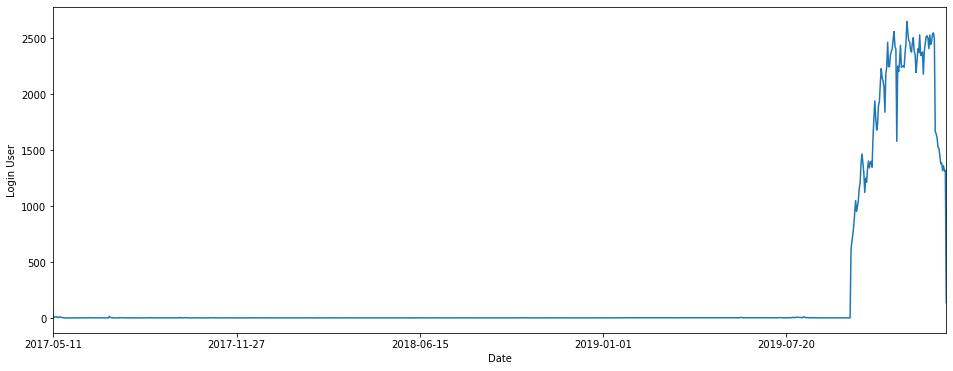

In [28]:
action.logdate.value_counts().sort_index().plot(figsize = (16,6))
plt.xlabel('Date')
plt.ylabel('Login User')

과제 안내에서 최근 출시한 게임이라고 작성되어 있으며, 2019-10-01 부터 접속자수가 폭증하여 2019-10-01 이전에 접속 기록을 보유한 계정은 테스트 계정이라고 판단하고 삭제하였다.

In [29]:
del_UID_array = action[action['logdate']<'2019-10-01'].UID.unique()
delaction = action['UID'].isin(del_UID_array)
action = action[~delaction]

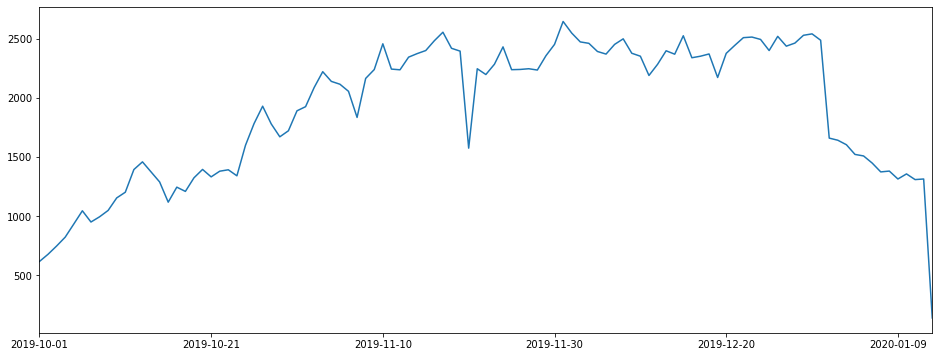

In [30]:
action.logdate.value_counts().sort_index().plot(figsize = (16,6))

Text(0, 0.5, 'user count')

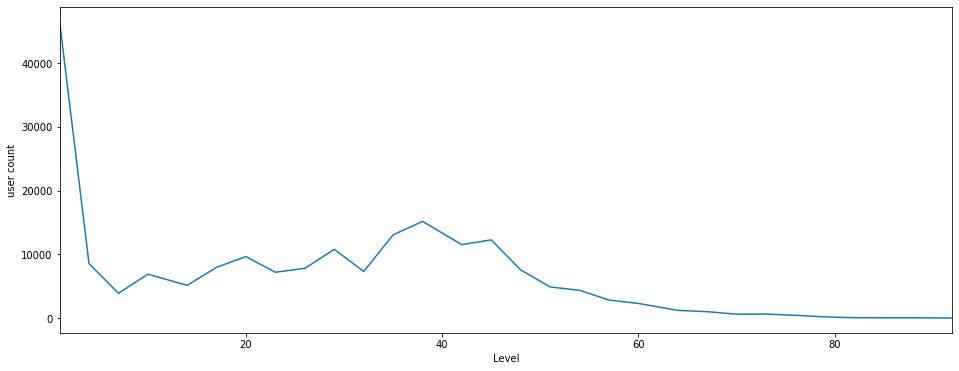

In [31]:
level = action['PlayerLevel'].value_counts()
level = level.sort_index()
level.plot(figsize = (16,6))
plt.xlabel('Level')
plt.ylabel('user count')

In [32]:
playtime_sum = action.groupby('UID').sum()['PlayTime']
purchase_sum = purchase.groupby("UID").sum()['product_price']
playtime_sum = pd.DataFrame(data = playtime_sum, columns = ['PlayTime'])
purchase_sum = pd.DataFrame(data = purchase_sum, columns = ['product_price'])

In [33]:
# #표준화
# nor_playtime = (playtime_sum - playtime_sum.mean())/playtime_sum.std()
# nor_purchase = (purchase_sum - purchase_sum.mean())/purchase_sum.std()

In [34]:
#정규화
nor_playtime = (playtime_sum - playtime_sum.min())/(playtime_sum.max() - playtime_sum.min())
nor_purchase = (purchase_sum - purchase_sum.min())/(purchase_sum.max() - purchase_sum.min())

In [35]:
merge_1 = pd.merge(nor_playtime, nor_purchase, on='UID', how = 'outer')
merge_index = merge_1['PlayTime'].dropna(axis=0).index
merge_1 = merge_1.loc[merge_index]
merge_1 = merge_1.fillna(0)

In [36]:
#standardization 말고 normalization 으로

In [37]:
from sklearn.cluster import KMeans

In [38]:
action_sum =  action.groupby(["UID",'logdate'], as_index = False).sum()
log_day = action_sum['UID'].value_counts()
log_day.index.name = 'UID'
log_day = pd.DataFrame(data = log_day)
log_day = log_day.rename(columns = {'UID':'log_day'})

In [39]:
time = pd.merge(playtime_sum,log_day,on = 'UID')

In [40]:
time['time_by_day'] = time['PlayTime']/time['log_day']

In [41]:
nor_time = (time['time_by_day'] - time['time_by_day'].min())/(time['time_by_day'].max() - time['time_by_day'].min())

In [42]:
nor_time

UID
1073365     0.003182
10322121    0.003571
13138783    0.001051
14160840    0.105918
14161452    0.053487
              ...   
29607412    0.021366
29607528    0.007559
29607552    0.002088
29607577    0.016169
29607615    0.000979
Name: time_by_day, Length: 57100, dtype: float64

In [43]:
merge_3 = pd.merge(merge_1, nor_time,on='UID')

In [44]:
merge_3 = merge_3[['PlayTime','product_price','time_by_day']]

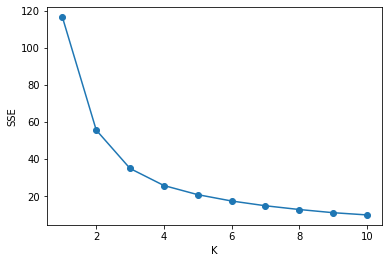

In [45]:
def elbow(X):
    sse = []
    for i in range(1,11):
        km = KMeans(n_clusters = i , algorithm = 'auto', random_state = 42)
        km.fit(X)
        sse.append(km.inertia_)
        
    plt.plot(range(1,11), sse, marker = 'o')
    plt.xlabel('K')
    plt.ylabel('SSE')
    plt.show()
elbow(merge_3)

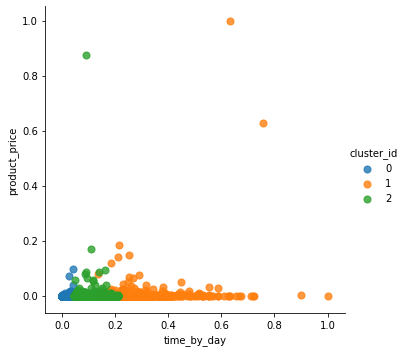

In [46]:
kmeans = KMeans(n_clusters=3).fit(merge_3)
kmeans.labels_
merge_3['cluster_id'] = kmeans.labels_
sns.lmplot('time_by_day','product_price',data = merge_3,fit_reg = False, scatter_kws = {"s":50}, hue = 'cluster_id')

In [47]:
max_action = action.groupby("UID").max()

In [48]:
merge_4 = pd.merge(merge_3,max_action,on='UID')

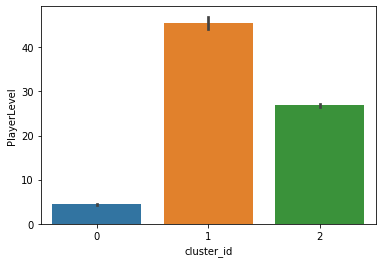

In [49]:
sns.barplot(data = merge_4, x='cluster_id',y='PlayerLevel')

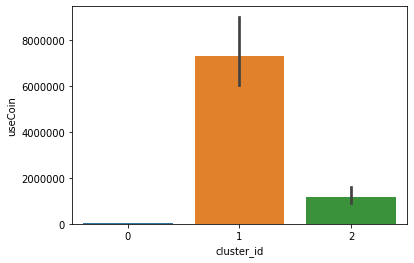

In [54]:
sns.barplot(data = merge_4, x='cluster_id',y='useCoin')

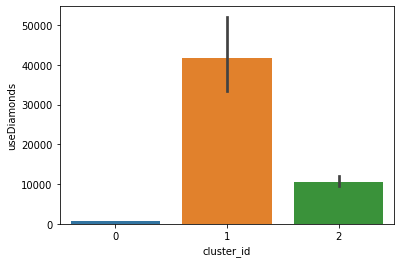

In [56]:
sns.barplot(data = merge_4, x='cluster_id',y='useDiamonds')

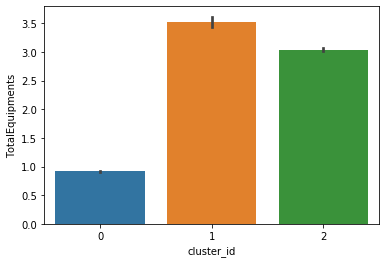

In [58]:
sns.barplot(data = merge_4, x='cluster_id',y='TotalEquipments')

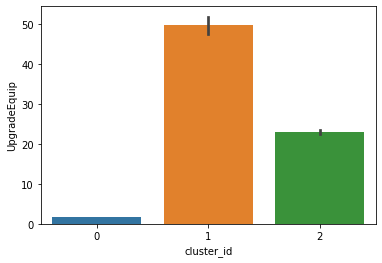

In [59]:
sns.barplot(data = merge_4, x ='cluster_id',y='UpgradeEquip')

In [92]:
for i in range(0, len(purchase)):
               purchase['logday'].iloc[i] = purchase['logtime'].iloc[i][0:10]

C:\Users\SukWoo\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [97]:
day_price = purchase.groupby('logday').sum()

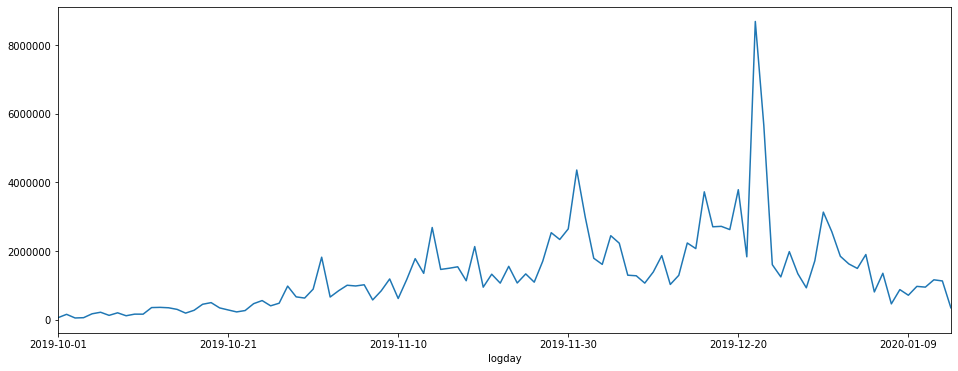

In [100]:
day_price['product_price'].plot(figsize = (16,6))

In [119]:
login_user_by_day = action.groupby('logdate').count()['UID']

In [171]:
sum_action = action.groupby("logdate",as_index = False).sum()
sum_purchase = purchase.groupby("logday", as_index = False).sum()
train = pd.merge(sum_action, sum_purchase, left_on = 'logdate', right_on = 'logday')
del train['UID_x'], train['logday'], train['UID_y']

In [192]:
train_y = train.iloc[:,[0,-1]]
train_x = train.iloc[:,:-1]

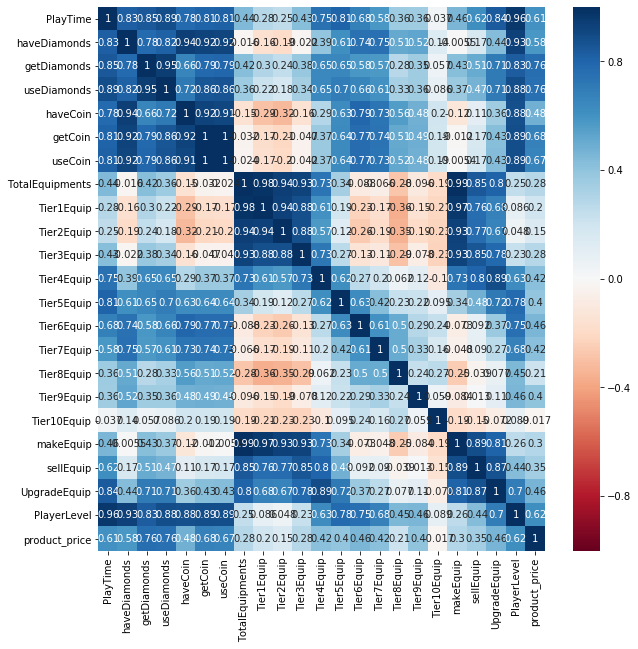

In [177]:
train_corr = train.corr()
plt.figure(figsize = (10,10))
ax = sns.heatmap(train_corr, cmap = "RdBu", annot = True, vmin = -1, vmax = 1)
ax.set_ylim(len(train_corr.columns),0)
plt.show()

In [216]:
import lightgbm as lgb
from lightgbm import plot_importance

X_train = train_x[train_x['logdate']<'2020-01-01'].iloc[:,1:]
X_test = train_x[train_x['logdate']>='2020-01-01'].iloc[:,1:]
y_train = train_y[train_y['logdate']<'2020-01-01']['product_price']
y_test = train_y[train_y['logdate']>='2020-01-01']['product_price']


lgb_train = lgb.Dataset(X_train, y_train)
params = {  'learning_rate': 0.01, 
            'max_depth': -1, 
            'boosting': 'gbdt', 
            'objective': 'regression', 
            'metric': 'mse', 
            'is_training_metric': True, 
            'num_leaves': 144, 
            'feature_fraction': 0.9,  
            'bagging_fraction': 0.7, 
            'bagging_freq': 5, 
            'seed':2020,
    
}

clf = lgb.train(params, lgb_train,num_boost_round=20000)

In [217]:
y_pred = clf.predict(X_test)

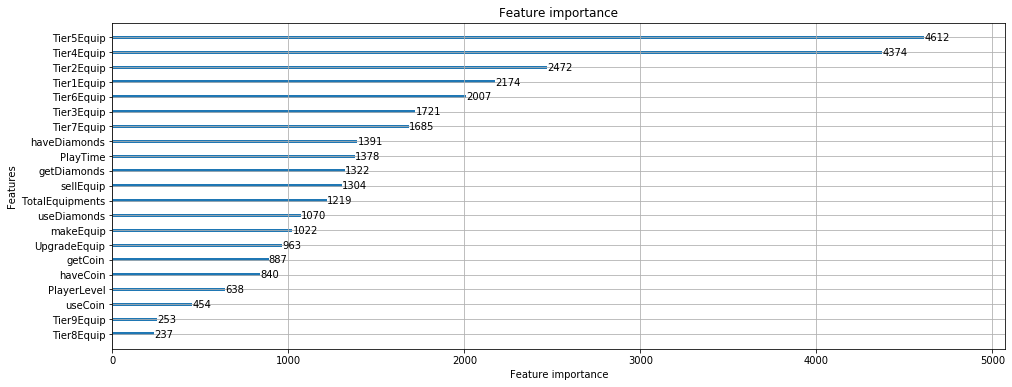

In [218]:
fig, ax = plt.subplots(figsize = (16,6))
plot_importance(clf, ax = ax)

In [223]:
def mean_squared_error(y, t):
    return np.sqrt((y-t)**2).mean(axis=None)

In [224]:
mean_squared_error(y_pred,y_test)

1300421.732308365

In [225]:
purchase

,UID,logtime,payID,product_id,product_price,logday
0,27878963,2019-10-01T05:58:55.574Z,P3863,package17,1800,2019-10-01
1,27878963,2019-10-01T05:59:15.330Z,P5067,package18,1800,2019-10-01
2,27878963,2019-10-01T05:59:35.823Z,P7328,package211,1800,2019-10-01
3,27878963,2019-10-01T05:59:55.685Z,P5742,package212,1800,2019-10-01
4,27878963,2019-10-01T06:04:47.071Z,P976,package122,24600,2019-10-01
...,...,...,...,...,...,...
13079,28919988,2020-01-14T08:26:48.543Z,P11983,package244,6600,2020-01-14
13080,28082720,2020-01-14T08:40:11.044Z,P7535,package215,1800,2020-01-14
13081,29443485,2020-01-14T08:42:11.247Z,P3756,package144,4200,2020-01-14
13082,28234675,2020-01-14T08:48:14.173Z,P8810,package215,1800,2020-01-14
